# TinyMS ResNet50 Tutorial

In this tutorial, using TinyMS API to train/serve a ResNet50 model will be demonstrated.  

## Prerequisite
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## Introduction

TinyMS is a high-level API which is designed for amateur of deep learning. It minimizes the number of actions of users required to construct, train, evaluate and serve a model. TinyMS also provides tutorials and documentations for developers. 

This tutorial consists of six parts, `constructing the model`, `downloading dataset`, `training`, `define servable json`, `starting server` and `making predictions` in which the server will be run in a sub process. 

In [1]:
import os
import json

from PIL import Image
from tinyms import context
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.data import Cifar10Dataset, download_dataset
from tinyms.vision import cifar10_transform, ImageViewer
from tinyms.model import Model, resnet50
from tinyms.callbacks import ModelCheckpoint, CheckpointConfig, LossMonitor
from tinyms.metrics import Accuracy
from tinyms.optimizers import Momentum
from tinyms.losses import SoftmaxCrossEntropyWithLogits

[WARNING] ME(12569:140321685239616,MainProcess):2021-03-19-15:21:33.633.399 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. Construct the model

TinyMS encapsulates init and construct of the ResNet50 model, the line of the code is reduced to construct the model:

In [2]:
# build the network
net = resnet50(class_num=10)
model = Model(net)

### 2. Download dataset

Training ResNet50 model with [cifar10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset will be demonstrated, while we provide two pre-trained ckpt files for users to download, one is trained with `cifar10` dataset and the other one is trained with [ImageNet2012](http://www.image-net.org/challenges/LSVRC/2012/) dataset.

In [3]:
# download the cifar10 dataset
cifar10_path = '/root/cifar10/cifar-10-batches-bin'
if not os.path.exists(cifar10_path):
    download_dataset('cifar10', '/root')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************** Downloading the Cifar10 dataset **************
[███████████████████████████████████████████████████████████████████████████████████████████████████ ] 99.81%************Download complete*************


### 3. Train the model & evaluation
The dataset for both training and evaluation will be defined here, and the parameters for training also set in this block. A trained ckpt file will be saved to `/etc/tinyms/serving/resnet50_cifar10` folder for later use, meanwhile the evaluation will be performed and the `Accuracy` can be checked
```
Notice: Since training ResNet50 on CPU is time consuming, we recommend skip training and using provided ckpt files to run. 
```

In [ ]:
# check ckpt folder exists or not
cifar10_ckpt_folder = '/etc/tinyms/serving/resnet50_cifar10'
cifar10_ckpt_path = '/etc/tinyms/serving/resnet50_cifar10/resnet50.ckpt'
if not os.path.exists(cifar10_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/resnet50_cifar10
else:
    print('resnet50_cifar10 ckpt folder already exists')

epoch_size = 90 # default is 90
batch_size = 32

# set environment parameters
dataset_sink_mode = False
device_target = "CPU"
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

# set dataset parameters
train_dataset = Cifar10Dataset(cifar10_path, num_parallel_workers=4, shuffle=True)
train_dataset = cifar10_transform.apply_ds(train_dataset, repeat_size=1, batch_size=32, is_training=True)
eval_dataset = Cifar10Dataset(cifar10_path, num_parallel_workers=4, shuffle=True)
eval_dataset = cifar10_transform.apply_ds(eval_dataset, repeat_size=1, batch_size=32, is_training=False)
step_size = train_dataset.get_dataset_size()

save_checkpoint_epochs = 5
ckpoint_cb = ModelCheckpoint(prefix="resnet_cifar10", config=CheckpointConfig(
            save_checkpoint_steps=save_checkpoint_epochs * train_dataset.get_dataset_size(),
            keep_checkpoint_max=10))

# define the loss function
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")

# define the optimizer
net_opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()), 0.01, 0.9)
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics={"Accuracy": Accuracy()})


print('************************Start training*************************')
model.train(epoch_size, train_dataset, callbacks=[ckpoint_cb, LossMonitor()],dataset_sink_mode=dataset_sink_mode)
model.save_checkpoint(ckpt_path)
print('************************Finished training*************************')

model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
acc = model.eval(eval_dataset, dataset_sink_mode=dataset_sink_mode)
print("============== Accuracy:{} ==============".format(acc))

```
Notice: If skipped training process, download the pretrained ckpt files and continue to serving
```
Click [resnet_imagenet](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt) to download resnet-imagenet ckpt file and click [resnet_cifar](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt) to download resnet-cifar ckpt file. Save this file to `/etc/tinyms/serving/resnet50_<dataset_name>/resnet50.ckpt`.

Or run the following code to download the `resnet_imagenet` and `resnet_cifar` ckpt file:

In [4]:
# check lenet folder exists or not, and download resnet50_imagenet
imagenet2012_ckpt_folder = '/etc/tinyms/serving/resnet50_imagenet2012'
imagenet2012_ckpt_path = '/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt'
if not os.path.exists(imagenet2012_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/resnet50_imagenet2012
    !wget -P /etc/tinyms/serving/resnet50_imagenet2012 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt
else:
    print('imagenet2012 ckpt folder already exists')
    if not os.path.exists(imagenet2012_ckpt_path):
        !wget -P /etc/tinyms/serving/resnet50_imagenet2012 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt   
    else:
        print('imagenet2012 ckpt file already exists')


# check lenet folder exists or not
cifar10_ckpt_folder = '/etc/tinyms/serving/resnet50_cifar10'
cifar10_ckpt_path = '/etc/tinyms/serving/resnet50_cifar10/resnet50.ckpt'
if not os.path.exists(cifar10_ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/resnet50_cifar10
    !wget -P /etc/tinyms/serving/resnet50_cifar10 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
else:
    print('cifar10 ckpt folder already exists')
    if not os.path.exists(cifar10_ckpt_path):
        !wget -P /etc/tinyms/serving/resnet50_cifar10 https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
    else:
        print('cifar10 ckpt file already exists')

imagenet2012 ckpt folder already exists
--2021-03-19 15:23:45--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/imagenet2012/resnet50.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 121.36.121.44, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188521005 (180M) [binary/octet-stream]
Saving to: ‘/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt’

resnet50.ckpt       100%[===================>] 179.79M  36.7MB/s    in 5.9s    

2021-03-19 15:23:52 (30.4 MB/s) - ‘/etc/tinyms/serving/resnet50_imagenet2012/resnet50.ckpt’ saved [188521005/188521005]

cifar10 ckpt folder already exists
--2021-03-19 15:23:52--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cifar10/resnet50.ckpt
Resolving asce

### 4. Define servable.json 

Choose only one of the following two code blocks to define the servable json file which will be used later

Run this code to define the servable json file for `ResNet50_imagenet2012` model:

In [5]:
servable_json = [{'name': 'resnet50_imagenet2012', 
                  'description': 'This servable hosts a resnet50 model predicting mushrooms', 
                  'model': {
                      "name": "resnet50", 
                      "format": "ckpt", 
                      "class_num": 9}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

Or run this code to define the servable json file for `ResNet50_cifar10` model:

In [ ]:
servable_json = [{'name': 'resnet50_cifar10', 
                  'description': 'This servable hosts a resnet50 model predicting 10 classes of objects', 
                  'model': {
                      "name": "resnet50", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. Start server

#### 5.1 Introduction
TinyMS Serving is a C/S(client/server) structure. There is a server and client. TinyMS using [Flask](https://flask.palletsprojects.com/en/1.1.x/) which is a micro web framework written in python as the C/S communication tool. In order to serve a model, user must start server first. If successfully started, the server will be run in a subprocess and listening to POST requests from 127.0.0.1 port 5000 sent by client and handle the requests using MindSpore backend which will construct the model, run the prediction and send the result back to the client.  

#### 5.2 start server
Run the following code block to start the server:

In [6]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 6. Make predictions

#### 6.1 Upload the pic

A picture is required to be the input. The `resnet_imagenet` ckpt requires a mushroom picture, while the `resnet_cifar` ckpt requires a picture of 
```
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```
Click [mushroom](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg) which is used in this tutorial for `resnet_imagenet` and [airplane](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg) for `resnet-cifar`. Upload the pic, if using terminal, either `scp` or `wget` will do, if running in Jupyter, click `Upload` button at the top right and select the picture. Save the picture at the root folder, rename to `mushroom.jpeg`(for resnet-imagenet) or `airplane.jpg`(for resnet-cifar).

Or run this code to download `mushroom` pic for `resnet_imagenet`  and `airplane` for `resnet_cifar`:

In [7]:
# download mushroom pic
if not os.path.exists('/root/mushroom.jpeg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg
else:
    print('mushroom.jpeg already exists')

# download airplane pic
if not os.path.exists('/root/airplane.jpg'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
else:
    print('airplane.jpg already exists')

--2021-03-19 15:24:11--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/mushrooms/mushroom.jpeg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 121.36.121.44, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76020 (74K) [image/jpeg]
Saving to: ‘/root/mushroom.jpeg’

mushroom.jpeg       100%[===================>]  74.24K   370KB/s    in 0.2s    

2021-03-19 15:24:12 (370 KB/s) - ‘/root/mushroom.jpeg’ saved [76020/76020]

--2021-03-19 15:24:12--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/objects/airplane.jpg
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 121.36.121.44, 49.4.112.5, ...
Connecting to as

####  6.2 List servables

Now, use `list_servables` function to check what model is servable right now.

In [8]:
list_servables()

[{'description': 'This servable hosts a resnet50 model predicting mushrooms',
  'model': {'class_num': 9, 'format': 'ckpt', 'name': 'resnet50'},
  'name': 'resnet50_imagenet2012'}]

If the output description shows it is a `resnet50` model, run the following code which will automatically detect whether it is a imagenet model or a cifar model

#### 6.3 Sending request and get the result

Run `predict` function to send the request, select between `TOP1_CLASS` and `TOP5_CLASS` to check the output

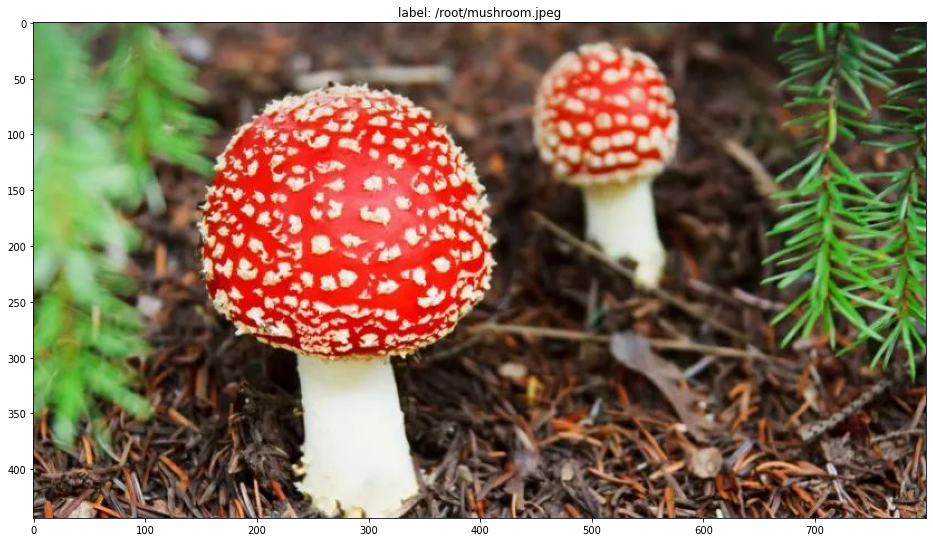

TOP1: Amanita毒蝇伞,伞菌目,鹅膏菌科,鹅膏菌属,主要分布于我国黑龙江、吉林、四川、西藏、云南等地,有毒, score: 0.99750286340713500977


In [9]:
# set image_path and output strategy
imagenet_image_path = "/root/mushroom.jpeg"
cifar_image_path = "/root/airplane.jpg"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset_name, strategy='TOP1_CLASS')
if server_started() is True:
    servable_name = list_servables()[0]['name']
    if servable_name == 'resnet50_imagenet2012':
        img_viewer = ImageViewer(Image.open(imagenet_image_path), imagenet_image_path)
        img_viewer.show()
        print(predict(imagenet_image_path, "resnet50_imagenet2012", "imagenet2012", strategy))
    else:
        img_viewer = ImageViewer(Image.open(cifar_image_path), cifar_image_path)
        img_viewer.show()
        print(predict(cifar_image_path, "resnet50_cifar10", 'cifar10', strategy))
else:
    print('Server not started')

## Check output

If user runs `resnet_imagenet` and see output similar to this:
```
TOP1: Amanita毒蝇伞,伞菌目,鹅膏菌科,鹅膏菌属,主要分布于我国黑龙江、吉林、四川、西藏、云南等地,有毒, score: 0.99119007587432861328
```
that means the prediction result is returned and the inference is completed.

Or user runs `resnet_cifar`, and the output is expected to be like this:
```
TOP1: airplane, score: 0.99997282028198242188
```

 ## Change model
 
Run another `servable_json` code block.
 
## Shutdown server

In [10]:
shutdown()

'Server shutting down...'